In [42]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR ,ReduceLROnPlateau
import time 

In [43]:
E_modulus = 200  
C1, C2 = 400, 600
noise_level = 0  
def generate_nonlinear_elastic_data(epsilon_values, E, C1, C2, noise_level):
    sigma = E * epsilon_values + C1 * epsilon_values ** 2 + C2 * epsilon_values ** 3
    noise = noise_level * np.random.randn(*epsilon_values.shape)
    return sigma + noise
epsilon_train = np.linspace(0, 0.3, 100).reshape(-1, 1).astype(np.float32)
sigma_train = generate_nonlinear_elastic_data(epsilon_train, E_modulus, C1, C2, noise_level).astype(np.float32)
epsilon_train_tensor = torch.tensor(epsilon_train)
sigma_train_tensor = torch.tensor(sigma_train)
std_train_stress = torch.std(sigma_train_tensor).item()
# Normalize the data using min-max normalization
x_data = epsilon_train_tensor.numpy()
y_data = sigma_train_tensor.numpy()
x_min, x_max = x_data.min(), x_data.max()
y_min, y_max = y_data.min(), y_data.max()
x_data = (x_data - x_min) / (x_max - x_min)
y_data = (y_data - y_min) / (y_max - y_min)
x_tensor = torch.tensor(x_data, dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.float32)
# Create DataLoader for shuffling
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


C:\Users\A_structure\AppData\Local\Temp\ipykernel_9024\918422316.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  "MI_ICNN_Loss Type A": torch.load("trained_model_lossty

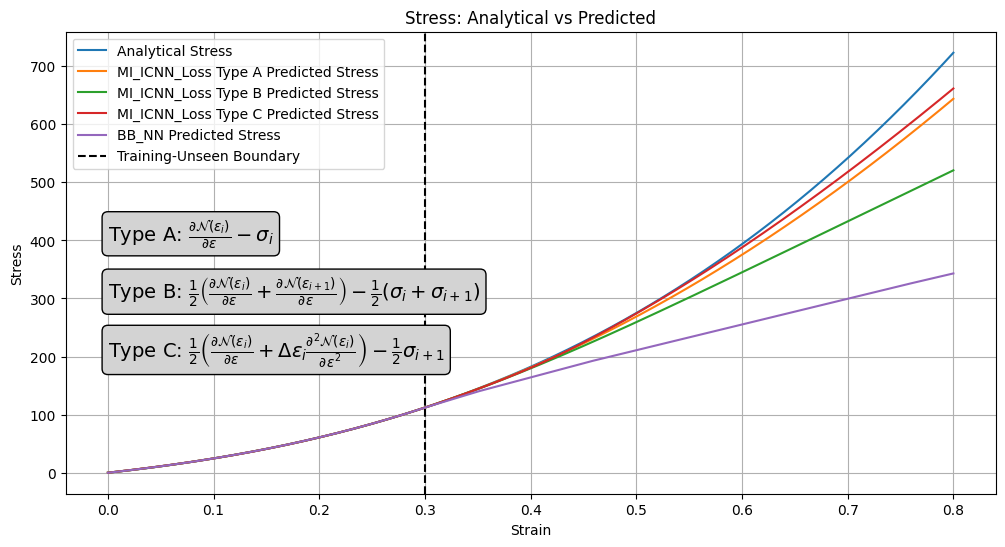

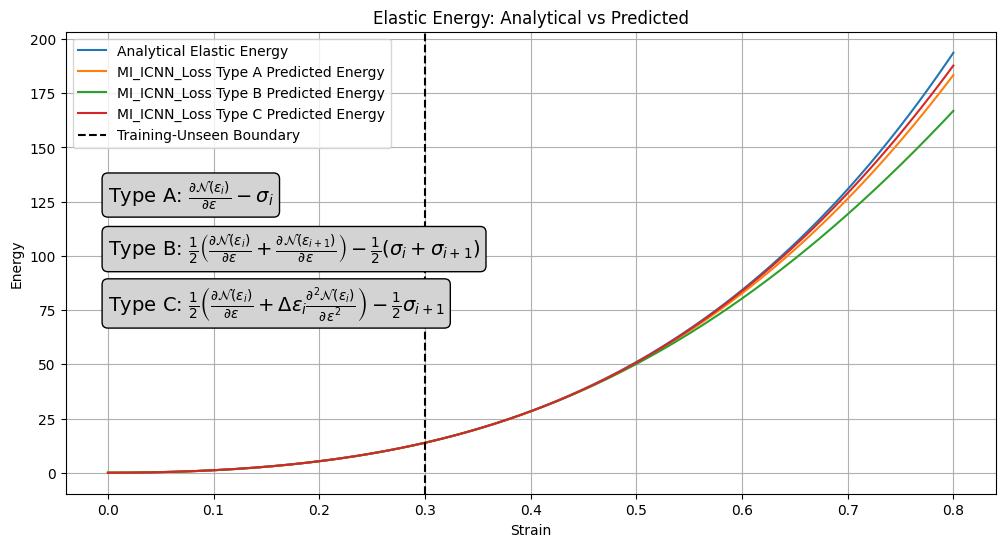

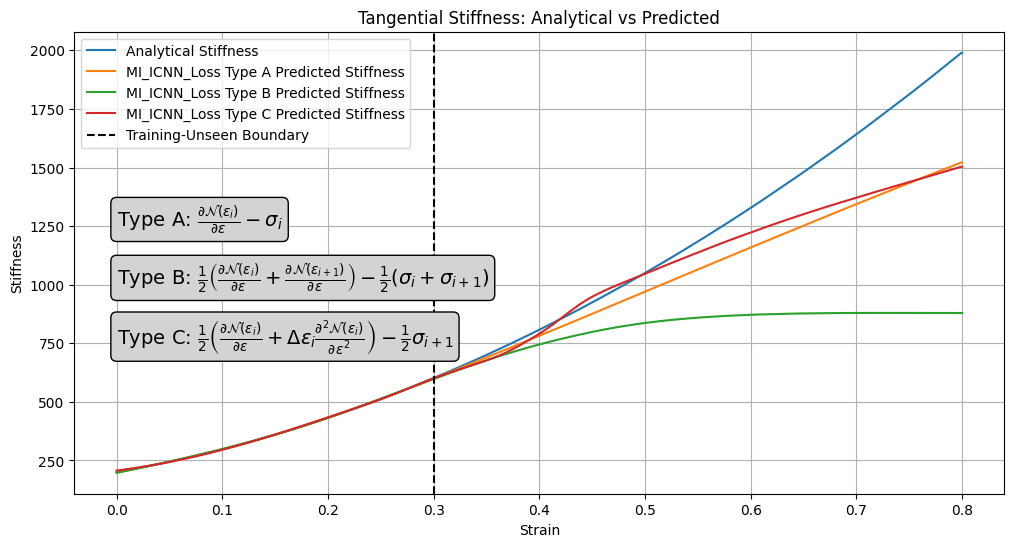

In [87]:

# Function to denormalize data
def denormalize(data, data_min, data_max):
    return data * (data_max - data_min) + data_min

# Adjust denormalization for energy
def denormalize_energy(energy, x_min, x_max, y_min, y_max):
    x_scale = x_max - x_min
    y_scale = y_max - y_min
    return energy * (x_scale * y_scale)

# Load models
models = {
    "MI_ICNN_Loss Type A": torch.load("trained_model_losstype_a_10K.pth"),
    "MI_ICNN_Loss Type B": torch.load("trained_model_losstype_b_10K.pth"),
    "MI_ICNN_Loss Type C": torch.load("trained_model_losstype_c_10K.pth"),
}
for model in models.values():
    model.eval()

# Load black-box model
model_bb = torch.load("black_box_nn.pth")
model_bb.eval()

# Initialize lists for results
results = {key: {"pred_energy": [], "pred_stress": []} for key in models}
real_results = {"strain": [], "real_energy": [], "real_stress": []}

# Generate validation data
epsilon_validation = np.linspace(0, 0.8, 700).reshape(-1, 1).astype(np.float32)
sigma_validation = generate_nonlinear_elastic_data(
    epsilon_validation, E_modulus, C1, C2, noise_level
).astype(np.float32)

# Normalize data
x_data = (epsilon_validation - x_min) / (x_max - x_min)
y_data = (sigma_validation - y_min) / (y_max - y_min)
x_tensor = torch.tensor(x_data, dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.float32)
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Process each model
for model_name, model in models.items():
    for batch_x, batch_y in dataloader:
        batch_x.requires_grad_()
        pred_energy = model(batch_x)
        pred_stress = torch.autograd.grad(pred_energy, batch_x, create_graph=True)[0]

        pred_energy = denormalize_energy(pred_energy.detach().numpy(), x_min, x_max, y_min, y_max)
        pred_stress = denormalize(pred_stress.detach().numpy(), y_min, y_max)

        results[model_name]["pred_energy"].append(pred_energy)
        results[model_name]["pred_stress"].append(pred_stress)

# Compute real values (same for all models)
for batch_x, batch_y in dataloader:
    strain = denormalize(batch_x.detach().numpy(), x_min, x_max)
    real_stress = denormalize(batch_y.detach().numpy(), y_min, y_max)
    real_energy = 0.5 * E_modulus * strain ** 2 + (C1 / 3) * strain ** 3 + (C2 / 4) * strain ** 4

    real_results["strain"].append(strain)
    real_results["real_energy"].append(real_energy)
    real_results["real_stress"].append(real_stress)

# Black-box predictions
pred_sigma_test = model_bb(torch.tensor(epsilon_validation)).detach().numpy()

# Plot stress
plt.figure(figsize=(12, 6))
plt.plot(np.concatenate(real_results["strain"]), np.concatenate(real_results["real_stress"]), label='Analytical Stress')
for model_name, data in results.items():
    plt.plot(np.concatenate(real_results["strain"]), np.concatenate(data["pred_stress"]), label=f'{model_name} Predicted Stress')
plt.plot(epsilon_validation, pred_sigma_test, label='BB_NN Predicted Stress')
plt.axvline(x=0.3, color='black', linestyle='--', label='Training-Unseen Boundary')
plt.xlabel('Strain')
plt.ylabel('Stress')
plt.title('Stress: Analytical vs Predicted')
plt.legend()
plt.grid()
Loss_A = r"\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} - \sigma_i"
Loss_B = r"\frac{1}{2}\left(\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} + \frac{\partial \mathcal{N}\left(\varepsilon_{i+1}\right)}{\partial \varepsilon}\right) - \frac{1}{2}\left(\sigma_i + \sigma_{i+1}\right)"
Loss_C = r"\frac{1}{2}\left(\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} + \Delta \varepsilon_i \frac{\partial^2 \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon^2}\right) - \frac{1}{2}\sigma_{i+1}"

plt.text(0.0, 400, "Type A: " + f"${Loss_A}$",
         fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))
plt.text(0, 300, "Type B: " + f"${Loss_B}$",
         fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))
plt.text(0, 200, "Type C: " + f"${Loss_C}$",
         fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))
plt.show()







# Plot energy
plt.figure(figsize=(12, 6))
plt.plot(np.concatenate(real_results["strain"]), np.concatenate(real_results["real_energy"]), label='Analytical Elastic Energy')
for model_name, data in results.items():
    plt.plot(np.concatenate(real_results["strain"]), np.concatenate(data["pred_energy"]), label=f'{model_name} Predicted Energy')
plt.axvline(x=0.3, color='black', linestyle='--', label='Training-Unseen Boundary')
plt.xlabel('Strain')
plt.ylabel('Energy')
plt.title('Elastic Energy: Analytical vs Predicted')
plt.legend()
plt.grid()
Loss_A = r"\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} - \sigma_i"
Loss_B = r"\frac{1}{2}\left(\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} + \frac{\partial \mathcal{N}\left(\varepsilon_{i+1}\right)}{\partial \varepsilon}\right) - \frac{1}{2}\left(\sigma_i + \sigma_{i+1}\right)"
Loss_C = r"\frac{1}{2}\left(\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} + \Delta \varepsilon_i \frac{\partial^2 \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon^2}\right) - \frac{1}{2}\sigma_{i+1}"

plt.text(0, 125, "Type A: " + f"${Loss_A}$",
         fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))
plt.text(0, 100, "Type B: " + f"${Loss_B}$",
         fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))
plt.text(0, 75, "Type C: " + f"${Loss_C}$",
         fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))
plt.show()

# Compute and plot stiffness
plt.figure(figsize=(12, 6))
real_stiffness = np.gradient(np.concatenate(real_results["real_stress"]).flatten(), np.concatenate(real_results["strain"]).flatten())
plt.plot(np.concatenate(real_results["strain"]), real_stiffness, label='Analytical Stiffness')
for model_name, data in results.items():
    pred_stiffness = np.gradient(np.concatenate(data["pred_stress"]).flatten(), np.concatenate(real_results["strain"]).flatten())
    plt.plot(np.concatenate(real_results["strain"]), pred_stiffness, label=f'{model_name} Predicted Stiffness')
plt.axvline(x=0.3, color='black', linestyle='--', label='Training-Unseen Boundary')
plt.xlabel('Strain')
plt.ylabel('Stiffness')
plt.title('Tangential Stiffness: Analytical vs Predicted')
plt.legend()
plt.grid()

Loss_A = r"\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} - \sigma_i"
Loss_B = r"\frac{1}{2}\left(\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} + \frac{\partial \mathcal{N}\left(\varepsilon_{i+1}\right)}{\partial \varepsilon}\right) - \frac{1}{2}\left(\sigma_i + \sigma_{i+1}\right)"
Loss_C = r"\frac{1}{2}\left(\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} + \Delta \varepsilon_i \frac{\partial^2 \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon^2}\right) - \frac{1}{2}\sigma_{i+1}"

plt.text(0, 1250, "Type A: " + f"${Loss_A}$",
         fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))
plt.text(0, 1000, "Type B: " + f"${Loss_B}$",
         fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))
plt.text(0, 750, "Type C: " + f"${Loss_C}$",
         fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))
plt.show()





C:\Users\A_structure\AppData\Local\Temp\ipykernel_9024\2971584225.py:5: RuntimeWarning: invalid value encountered in divide
  normalized_error = error_stress / np.abs(np.concatenate(real_results["real_stress"]))
C:\Users\A_structure\AppData\Local\Temp\ipykernel_9024\2971584225.py:10: RuntimeWarning: divide by zero encountered in divide
  bb_normalized_error = bb_error_stress / np.abs(np.concatenate(real_results["real_stress"]))


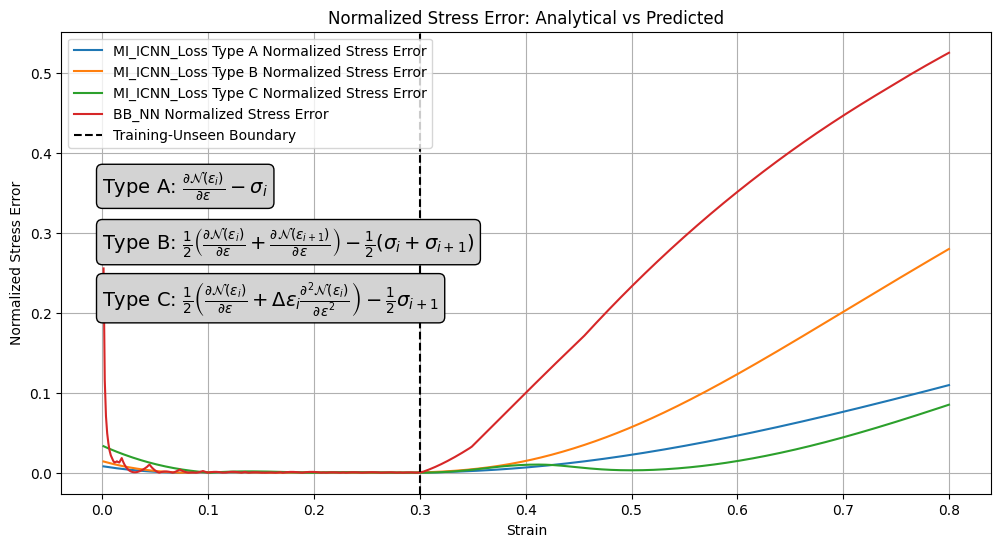

C:\Users\A_structure\AppData\Local\Temp\ipykernel_9024\2971584225.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_error_energy = error_energy / np.abs(np.concatenate(real_results["real_energy"]))


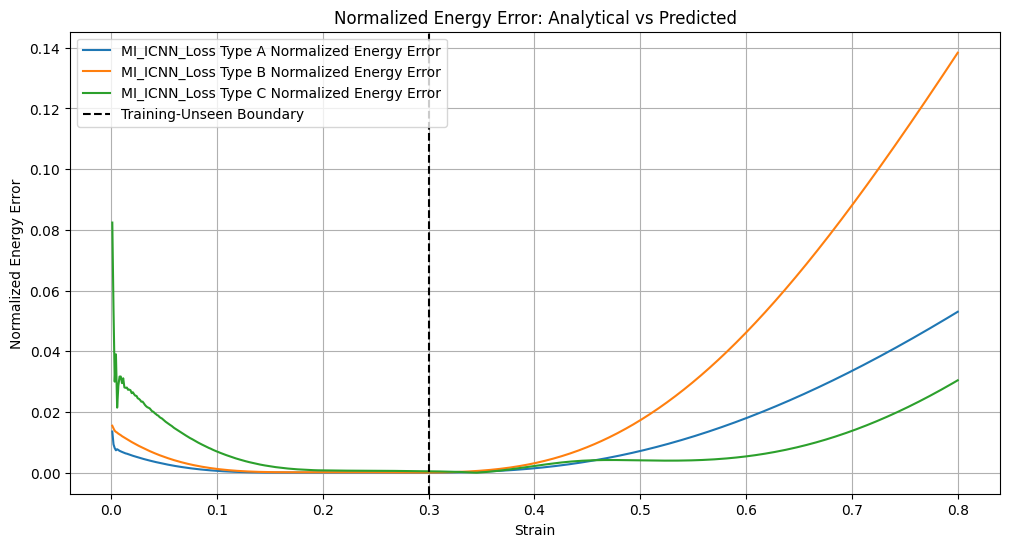

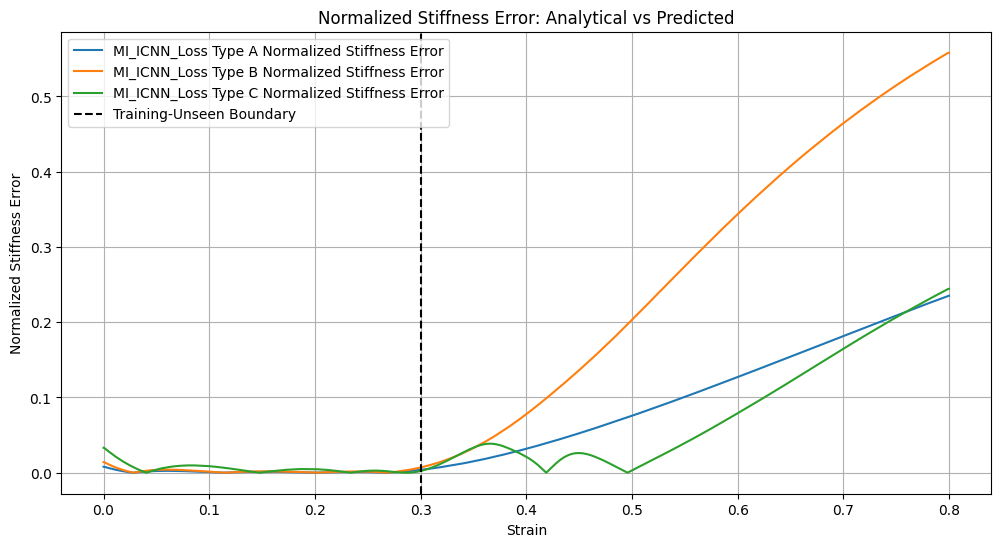

In [105]:
# Plot normalized error between analytical and predicted stress
plt.figure(figsize=(12, 6))
for model_name, data in results.items():
    error_stress = np.abs(np.concatenate(real_results["real_stress"]) - np.concatenate(data["pred_stress"]))
    normalized_error = error_stress / np.abs(np.concatenate(real_results["real_stress"]))
    plt.plot(np.concatenate(real_results["strain"]), normalized_error, label=f'{model_name} Normalized Stress Error')

# Add black-box error analysis for stress
bb_error_stress = np.abs(np.concatenate(real_results["real_stress"]) - pred_sigma_test)
bb_normalized_error = bb_error_stress / np.abs(np.concatenate(real_results["real_stress"]))
plt.plot(np.concatenate(real_results["strain"]), bb_normalized_error, label='BB_NN Normalized Stress Error')

plt.axvline(x=0.3, color='black', linestyle='--', label='Training-Unseen Boundary')
plt.xlabel('Strain')
plt.ylabel('Normalized Stress Error')
plt.title('Normalized Stress Error: Analytical vs Predicted')
plt.legend()
plt.grid()
Loss_A = r"\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} - \sigma_i"
Loss_B = r"\frac{1}{2}\left(\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} + \frac{\partial \mathcal{N}\left(\varepsilon_{i+1}\right)}{\partial \varepsilon}\right) - \frac{1}{2}\left(\sigma_i + \sigma_{i+1}\right)"
Loss_C = r"\frac{1}{2}\left(\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} + \Delta \varepsilon_i \frac{\partial^2 \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon^2}\right) - \frac{1}{2}\sigma_{i+1}"

plt.text(0, 0.35, "Type A: " + f"${Loss_A}$",
         fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))
plt.text(0, 0.28, "Type B: " + f"${Loss_B}$",
         fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))
plt.text(0, 0.21, "Type C: " + f"${Loss_C}$",
         fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))
plt.show()

# Plot normalized error between analytical and predicted energy
plt.figure(figsize=(12, 6))
for model_name, data in results.items():
    error_energy = np.abs(np.concatenate(real_results["real_energy"]) - np.concatenate(data["pred_energy"]))
    normalized_error_energy = error_energy / np.abs(np.concatenate(real_results["real_energy"]))
    plt.plot(np.concatenate(real_results["strain"]), normalized_error_energy, label=f'{model_name} Normalized Energy Error')

plt.axvline(x=0.3, color='black', linestyle='--', label='Training-Unseen Boundary')
plt.xlabel('Strain')
plt.ylabel('Normalized Energy Error')
plt.title('Normalized Energy Error: Analytical vs Predicted')
plt.legend()
plt.grid()
plt.show()

# Plot normalized error between analytical and predicted stiffness
plt.figure(figsize=(12, 6))
real_stiffness = np.gradient(np.concatenate(real_results["real_stress"]).flatten(), np.concatenate(real_results["strain"]).flatten())
for model_name, data in results.items():
    pred_stiffness = np.gradient(np.concatenate(data["pred_stress"]).flatten(), np.concatenate(real_results["strain"]).flatten())
    error_stiffness = np.abs(real_stiffness - pred_stiffness)
    normalized_error_stiffness = error_stiffness / np.abs(real_stiffness)
    plt.plot(np.concatenate(real_results["strain"]), normalized_error_stiffness, label=f'{model_name} Normalized Stiffness Error')

plt.axvline(x=0.3, color='black', linestyle='--', label='Training-Unseen Boundary')
plt.xlabel('Strain')
plt.ylabel('Normalized Stiffness Error')
plt.title('Normalized Stiffness Error: Analytical vs Predicted')
plt.legend()
plt.grid()
plt.show()


C:\Users\A_structure\AppData\Local\Temp\ipykernel_9024\1833327218.py:5: RuntimeWarning: invalid value encountered in divide
  normalized_error = error_stress / np.abs(np.concatenate(real_results["real_stress"]))
C:\Users\A_structure\AppData\Local\Temp\ipykernel_9024\1833327218.py:10: RuntimeWarning: divide by zero encountered in divide
  bb_normalized_error = bb_error_stress / np.abs(np.concatenate(real_results["real_stress"]))


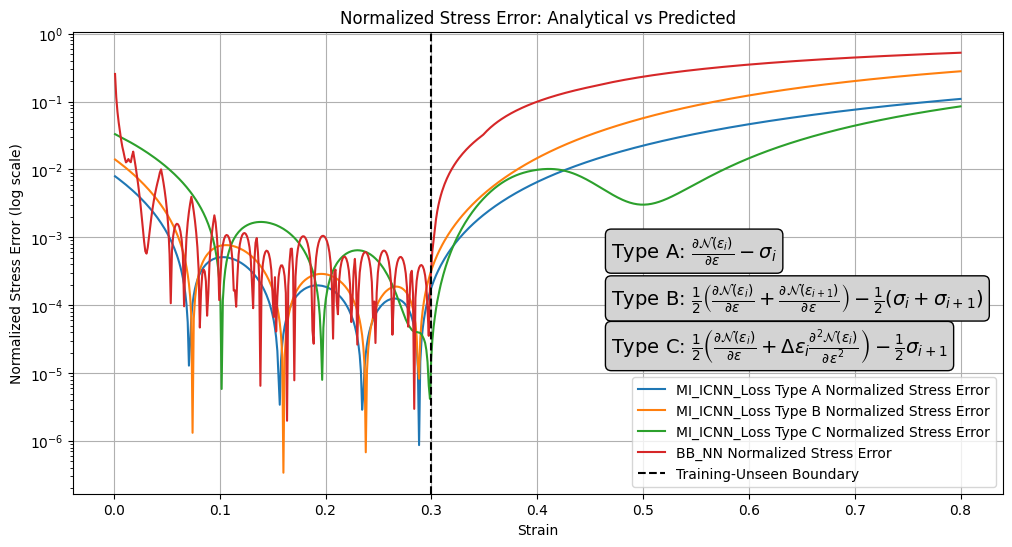

C:\Users\A_structure\AppData\Local\Temp\ipykernel_9024\1833327218.py:36: RuntimeWarning: invalid value encountered in divide
  normalized_error_energy = error_energy / np.abs(np.concatenate(real_results["real_energy"]))


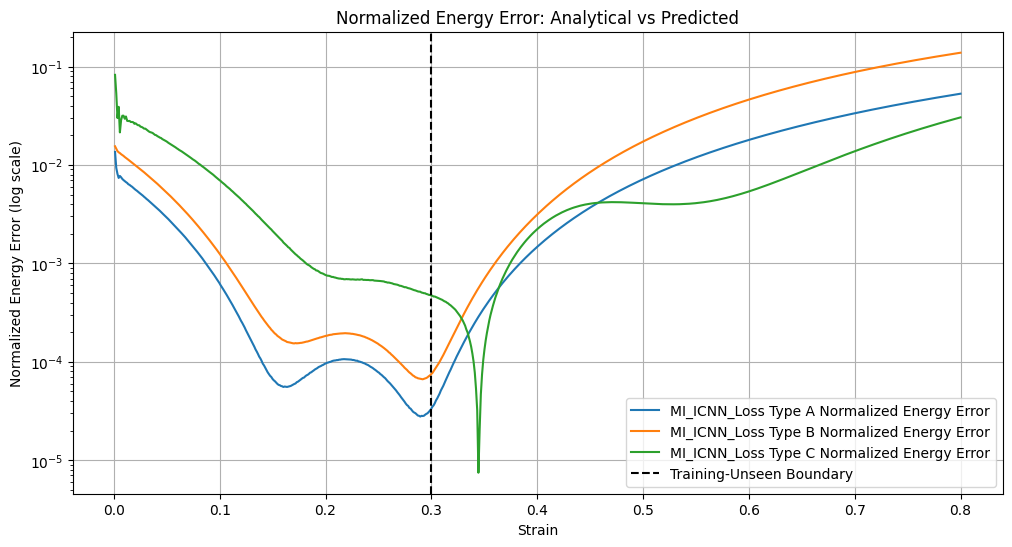

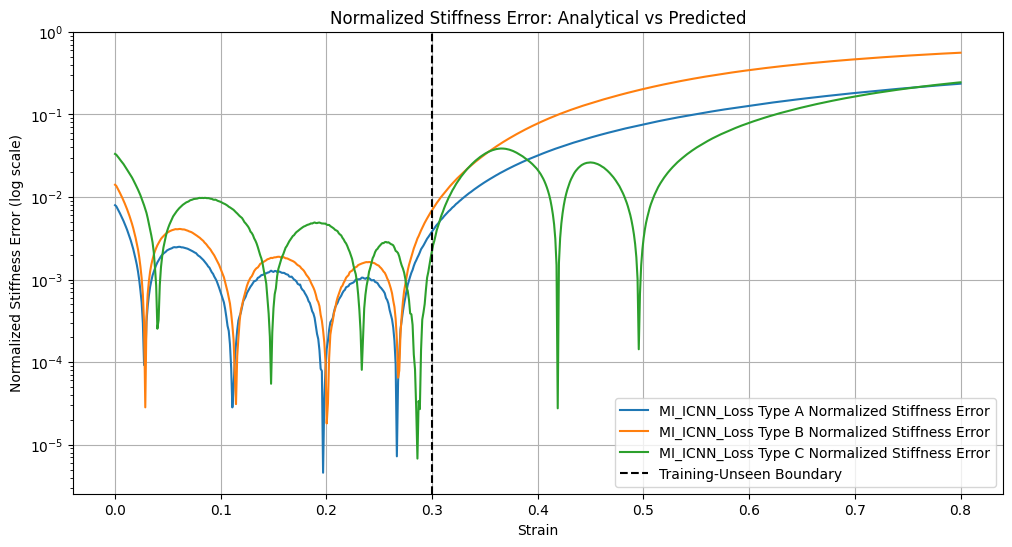

In [101]:

# Plot normalized error between analytical and predicted stress
plt.figure(figsize=(12, 6))
for model_name, data in results.items():
    error_stress = np.abs(np.concatenate(real_results["real_stress"]) - np.concatenate(data["pred_stress"]))
    normalized_error = error_stress / np.abs(np.concatenate(real_results["real_stress"]))
    plt.plot(np.concatenate(real_results["strain"]), normalized_error, label=f'{model_name} Normalized Stress Error')

# Add black-box error analysis for stress
bb_error_stress = np.abs(np.concatenate(real_results["real_stress"]) - pred_sigma_test)
bb_normalized_error = bb_error_stress / np.abs(np.concatenate(real_results["real_stress"]))
plt.plot(np.concatenate(real_results["strain"]), bb_normalized_error, label='BB_NN Normalized Stress Error')

plt.axvline(x=0.3, color='black', linestyle='--', label='Training-Unseen Boundary')
plt.yscale('log')  # Use logarithmic scale for better visibility of small errors
plt.xlabel('Strain')
plt.ylabel('Normalized Stress Error (log scale)')
plt.title('Normalized Stress Error: Analytical vs Predicted')
plt.legend()
plt.grid()
Loss_A = r"\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} - \sigma_i"
Loss_B = r"\frac{1}{2}\left(\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} + \frac{\partial \mathcal{N}\left(\varepsilon_{i+1}\right)}{\partial \varepsilon}\right) - \frac{1}{2}\left(\sigma_i + \sigma_{i+1}\right)"
Loss_C = r"\frac{1}{2}\left(\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} + \Delta \varepsilon_i \frac{\partial^2 \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon^2}\right) - \frac{1}{2}\sigma_{i+1}"

plt.text(0.47, 0.0005, "Type A: " + f"${Loss_A}$",
         fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))
plt.text(0.47, 0.0001, "Type B: " + f"${Loss_B}$",
         fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))
plt.text(0.47, 0.00002, "Type C: " + f"${Loss_C}$",
         fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))
plt.show()

# Plot normalized error between analytical and predicted energy
plt.figure(figsize=(12, 6))
for model_name, data in results.items():
    error_energy = np.abs(np.concatenate(real_results["real_energy"]) - np.concatenate(data["pred_energy"]))
    normalized_error_energy = error_energy / np.abs(np.concatenate(real_results["real_energy"]))
    plt.plot(np.concatenate(real_results["strain"]), normalized_error_energy, label=f'{model_name} Normalized Energy Error')

plt.axvline(x=0.3, color='black', linestyle='--', label='Training-Unseen Boundary')
plt.yscale('log')  # Use logarithmic scale for better visibility of small errors
plt.xlabel('Strain')
plt.ylabel('Normalized Energy Error (log scale)')
plt.title('Normalized Energy Error: Analytical vs Predicted')
plt.legend()
plt.grid()
Loss_A = r"\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} - \sigma_i"
Loss_B = r"\frac{1}{2}\left(\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} + \frac{\partial \mathcal{N}\left(\varepsilon_{i+1}\right)}{\partial \varepsilon}\right) - \frac{1}{2}\left(\sigma_i + \sigma_{i+1}\right)"
Loss_C = r"\frac{1}{2}\left(\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} + \Delta \varepsilon_i \frac{\partial^2 \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon^2}\right) - \frac{1}{2}\sigma_{i+1}"

plt.show()

# Plot normalized error between analytical and predicted stiffness
plt.figure(figsize=(12, 6))
real_stiffness = np.gradient(np.concatenate(real_results["real_stress"]).flatten(), np.concatenate(real_results["strain"]).flatten())
for model_name, data in results.items():
    pred_stiffness = np.gradient(np.concatenate(data["pred_stress"]).flatten(), np.concatenate(real_results["strain"]).flatten())
    error_stiffness = np.abs(real_stiffness - pred_stiffness)
    normalized_error_stiffness = error_stiffness / np.abs(real_stiffness)
    plt.plot(np.concatenate(real_results["strain"]), normalized_error_stiffness, label=f'{model_name} Normalized Stiffness Error')


plt.axvline(x=0.3, color='black', linestyle='--', label='Training-Unseen Boundary')
plt.yscale('log')  # Use logarithmic scale for better visibility of small errors
plt.xlabel('Strain')
plt.ylabel('Normalized Stiffness Error (log scale)')
plt.title('Normalized Stiffness Error: Analytical vs Predicted')
plt.legend()
plt.grid()
Loss_A = r"\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} - \sigma_i"
Loss_B = r"\frac{1}{2}\left(\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} + \frac{\partial \mathcal{N}\left(\varepsilon_{i+1}\right)}{\partial \varepsilon}\right) - \frac{1}{2}\left(\sigma_i + \sigma_{i+1}\right)"
Loss_C = r"\frac{1}{2}\left(\frac{\partial \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon} + \Delta \varepsilon_i \frac{\partial^2 \mathcal{N}\left(\varepsilon_i\right)}{\partial \varepsilon^2}\right) - \frac{1}{2}\sigma_{i+1}"
plt.show()
